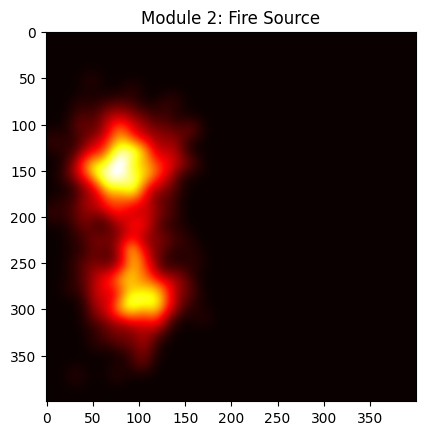

In [98]:
# Module 2 (Fire Generation)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Define a shared grid size so both modules match
GRID_SIZE = (400, 400)

def generate_fire_data():
    height, width = GRID_SIZE
    binary_fire_grid = np.zeros((height, width), dtype=np.float32)

    num_fires = 600
    for _ in range(num_fires):
        # (Using the logic you already have for clusters)
        if np.random.rand() > 0.4:
            cy, cx = 150, 80
            y = int(np.random.normal(cy, 35))
            x = int(np.random.normal(cx, 30))
        else:
            cy, cx = 280, 100
            y = int(np.random.normal(cy, 30))
            x = int(np.random.normal(cx, 25))

        y = np.clip(y, 0, height - 1)
        x = np.clip(x, 0, width - 1)
        binary_fire_grid[y, x] = 1.0

    # Generate the heatmap for Module 2 display
    heatmap = gaussian_filter(binary_fire_grid, sigma=10)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Return BOTH the heatmap (for display) and the raw binary grid (for Module 1)
    return heatmap, binary_fire_grid

# Run the function and save to variables
mod2_heatmap, shared_fire_grid = generate_fire_data()

# Plotting Module 2 (Optional)
plt.imshow(mod2_heatmap, cmap='hot')
plt.title("Module 2: Fire Source")
plt.show()

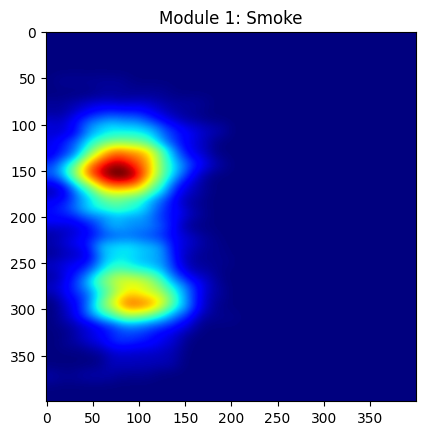

In [99]:
# Module 1 (Smoke Simulation)
import cv2

# Update function to accept the grid from Block 1
def generate_smoke_from_fires(input_fires):
    height, width = input_fires.shape

    # 1. Initialize AOD grid using the input fires
    # We multiply by 100 to give the fires "intensity" for the smoke generation
    aod_grid = input_fires * 100.0

    # Gaussian Blobs
    aod_grid = gaussian_filter(aod_grid, sigma=8)

    # Directional Motion Blur
    kernel_size = 80
    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size

    aod_transported = cv2.filter2D(aod_grid, -1, kernel_motion_blur)

    # Gradient Blending
    gradient = np.linspace(1.5, 0.4, width)
    gradient_mask = np.tile(gradient, (height, 1))
    aod_final = aod_transported * gradient_mask

    # Normalization
    aod_normalized = (aod_final - aod_final.min()) / (aod_final.max() - aod_final.min())
    aod_scaled = aod_normalized * (2.5 - 0.1) + 0.1

    return aod_scaled

# Call the function passing the variable from Block 1
mod1_smoke_map = generate_smoke_from_fires(shared_fire_grid)

# Plotting Module 1
plt.imshow(mod1_smoke_map, cmap='jet')
plt.title("Module 1: Smoke")
plt.show()

Using Module 1 data.


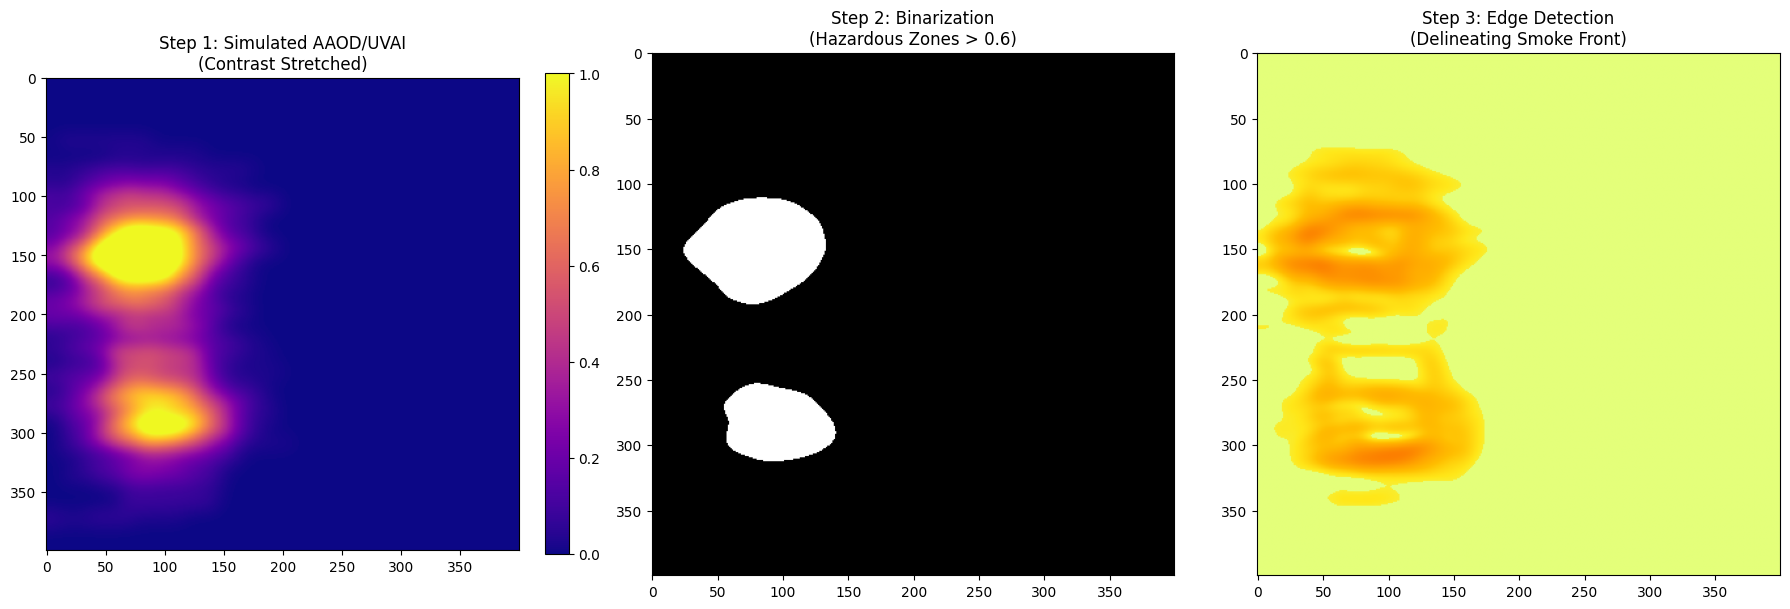

In [100]:
# Module 3 (AAOD & UVAI Simulation)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import sobel

def generate_aaod_and_edges(input_aod_map):
    """
    Takes the AOD map (Module 1) and processes it to simulate
    Absorbing Aerosol (AAOD) and detect smoke boundaries.
    """

    # ---------------------------------------------------------
    # DIP Technique 1: Contrast Stretching
    # ---------------------------------------------------------
    # Smoke absorption signals (UVAI) often require contrast enhancement
    # to distinguish the plume from the background earth/clouds.
    # We stretch the pixel values to fill the 0.0 - 1.0 range fully.

    p2, p98 = np.percentile(input_aod_map, (2, 98))
    aaod_stretched = np.clip((input_aod_map - p2) / (p98 - p2), 0, 1)

    # ---------------------------------------------------------
    # DIP Technique 2: Gradient Fields
    # ---------------------------------------------------------
    # We calculate the gradient magnitude. This simulates where the smoke
    # density is changing the fastest (the internal structure of the plume).

    gradient_y = np.gradient(aaod_stretched, axis=0)
    gradient_x = np.gradient(aaod_stretched, axis=1)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Normalize gradient for visualization
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max())

    # ---------------------------------------------------------
    # DIP Technique 3: Binarization (Hotspots)
    # ---------------------------------------------------------
    # We threshold the image to identify "Hazardous" zones.
    # Everything above 60% intensity is marked as a Core Hotspot.

    threshold_val = 0.60
    binary_hotspots = (aaod_stretched > threshold_val).astype(np.float32)

    # ---------------------------------------------------------
    # DIP Technique 4: Edge Detection (Smoke Front)
    # ---------------------------------------------------------
    # We use the Sobel operator to find the outer boundary of the smoke plume.
    # This helps scientists determine exactly how far the smoke has reached.

    sobel_x = cv2.Sobel(input_aod_map, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(input_aod_map, cv2.CV_64F, 0, 1, ksize=5)
    smoke_edges = np.sqrt(sobel_x**2 + sobel_y**2)

    # Clean up edges for display
    smoke_edges = smoke_edges / smoke_edges.max()
    smoke_edges[smoke_edges < 0.2] = 0 # Remove weak edges

    return aaod_stretched, binary_hotspots, smoke_edges

# --- Execution Logic ---

# CHECK: Do we have data from Module 1?
try:
    # Use the output from the previous block if it exists
    input_data = mod1_smoke_map
    print("Using Module 1 data.")
except NameError:
    # Fallback for independent testing
    print("Module 1 data not found. Generating dummy test data...")
    input_data = np.zeros((400, 400))
    cv2.circle(input_data, (100, 200), 80, 1, -1)
    input_data = cv2.GaussianBlur(input_data, (51, 51), 0)

# Run Module 3
aaod_map, hotspots, edges = generate_aaod_and_edges(input_data)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: AAOD / UVAI (Contrast Stretched)
# 'plasma' is excellent for UVAI as it mimics the purple/yellow satellite scans
im1 = axes[0].imshow(aaod_map, cmap='plasma')
axes[0].set_title('Step 1: Simulated AAOD/UVAI\n(Contrast Stretched)', fontsize=12)
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Plot 2: Binarization (Hotspots)
axes[1].imshow(hotspots, cmap='gray')
axes[1].set_title('Step 2: Binarization\n(Hazardous Zones > 0.6)', fontsize=12)

# Plot 3: Edge Detection (Smoke Front)
# We overlay edges on black for clarity
axes[2].imshow(edges, cmap='Wistia') # Wistia is a bright yellow/orange map
axes[2].set_title('Step 3: Edge Detection\n(Delineating Smoke Front)', fontsize=12)

plt.tight_layout()
plt.show()

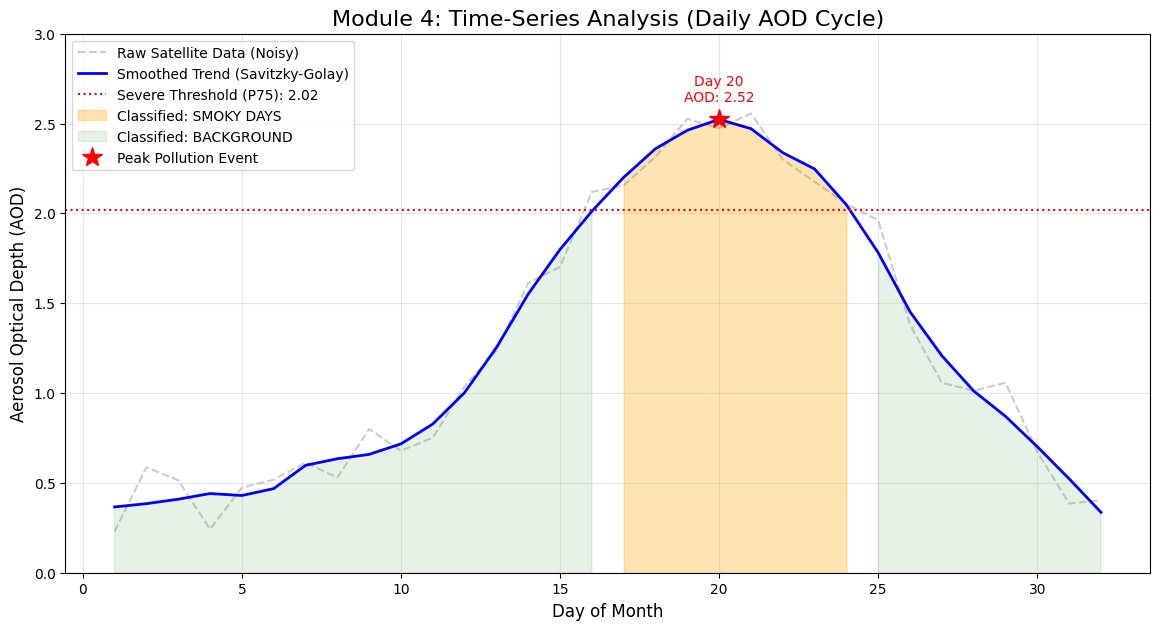

Binary Classification Mask (1=Smoky, 0=Background):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


In [101]:
# Module 4 (Time-Series Analysis)
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

def analyze_aod_timeseries():
    """
    Simulates a 32-day AOD extraction and applies 1D signal processing
    to classify days as 'Smoky' or 'Background'.
    """

    # ---------------------------------------------------------
    # 1. Generate Synthetic Data (The "Extraction")
    # ---------------------------------------------------------
    days = np.arange(1, 33) # 32 Days (e.g., Oct 15 - Nov 15)

    # Simulate the "Stubble Burning Season" trend
    # A bell curve peaking around Day 20
    seasonal_trend = np.exp(-(days - 20)**2 / (2 * 5**2))

    # Add random noise (simulating sensor error/clouds)
    noise = np.random.normal(0, 0.15, 32)

    # Construct the final raw signal
    # Baseline AOD (0.4) + Seasonal Spike (up to 2.5) + Noise
    raw_aod = 0.4 + (2.1 * seasonal_trend) + noise
    # Ensure no negative values
    raw_aod = np.clip(raw_aod, 0.1, 3.0)

    # ---------------------------------------------------------
    # DIP Technique 1: Smoothing (Savitzky-Golay Filter)
    # ---------------------------------------------------------
    # Unlike a simple average, Sav-Gol preserves the height of the peak
    # while removing the "jagged" noise.
    # window_length=7 (1 week smoothing), polyorder=2
    smoothed_aod = savgol_filter(raw_aod, window_length=7, polyorder=2)

    # ---------------------------------------------------------
    # DIP Technique 2: Percentile Thresholding (P25, P75)
    # ---------------------------------------------------------
    # We define "Background" as the bottom 25% of values.
    # We define "Smoky/Hazardous" as the top 25% of values.
    p25 = np.percentile(smoothed_aod, 25)
    p75 = np.percentile(smoothed_aod, 75)

    # ---------------------------------------------------------
    # DIP Technique 3: Peak Detection
    # ---------------------------------------------------------
    # Find the specific day where pollution maximized.
    peaks, _ = find_peaks(smoothed_aod, height=p75)

    # ---------------------------------------------------------
    # Classification (Binary Mask)
    # ---------------------------------------------------------
    # 1 = Smoky Day, 0 = Clean/Background Day
    smoky_mask = (smoothed_aod > p75).astype(int)

    return days, raw_aod, smoothed_aod, p75, peaks, smoky_mask

# --- Execution ---
days, raw, smooth, threshold, peaks, mask = analyze_aod_timeseries()

# --- Visualization ---
plt.figure(figsize=(14, 7))

# Plot 1: The Raw vs Smoothed Data
plt.plot(days, raw, color='gray', alpha=0.4, label='Raw Satellite Data (Noisy)', linestyle='--')
plt.plot(days, smooth, color='blue', linewidth=2, label='Smoothed Trend (Savitzky-Golay)')

# Plot 2: Threshold & Classification
plt.axhline(threshold, color='red', linestyle=':', label=f'Severe Threshold (P75): {threshold:.2f}')

# Highlight "Smoky Days"
plt.fill_between(days, 0, smooth, where=(smooth > threshold),
                 color='orange', alpha=0.3, label='Classified: SMOKY DAYS')

# Highlight "Background Days"
plt.fill_between(days, 0, smooth, where=(smooth <= threshold),
                 color='green', alpha=0.1, label='Classified: BACKGROUND')

# Mark the Peak
if len(peaks) > 0:
    peak_day = days[peaks[0]]
    peak_val = smooth[peaks[0]]
    plt.plot(peak_day, peak_val, 'r*', markersize=15, label='Peak Pollution Event')
    plt.text(peak_day, peak_val + 0.1, f'Day {peak_day}\nAOD: {peak_val:.2f}', ha='center', color='red')

# Formatting
plt.title('Module 4: Time-Series Analysis (Daily AOD Cycle)', fontsize=16)
plt.xlabel('Day of Month', fontsize=12)
plt.ylabel('Aerosol Optical Depth (AOD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0, 3.0)

plt.show()

# Print the Binary Classification Mask (The "Output" requirement)
print("Binary Classification Mask (1=Smoky, 0=Background):")
print(mask)

Successfully connected to Module 1 Smoke Map.


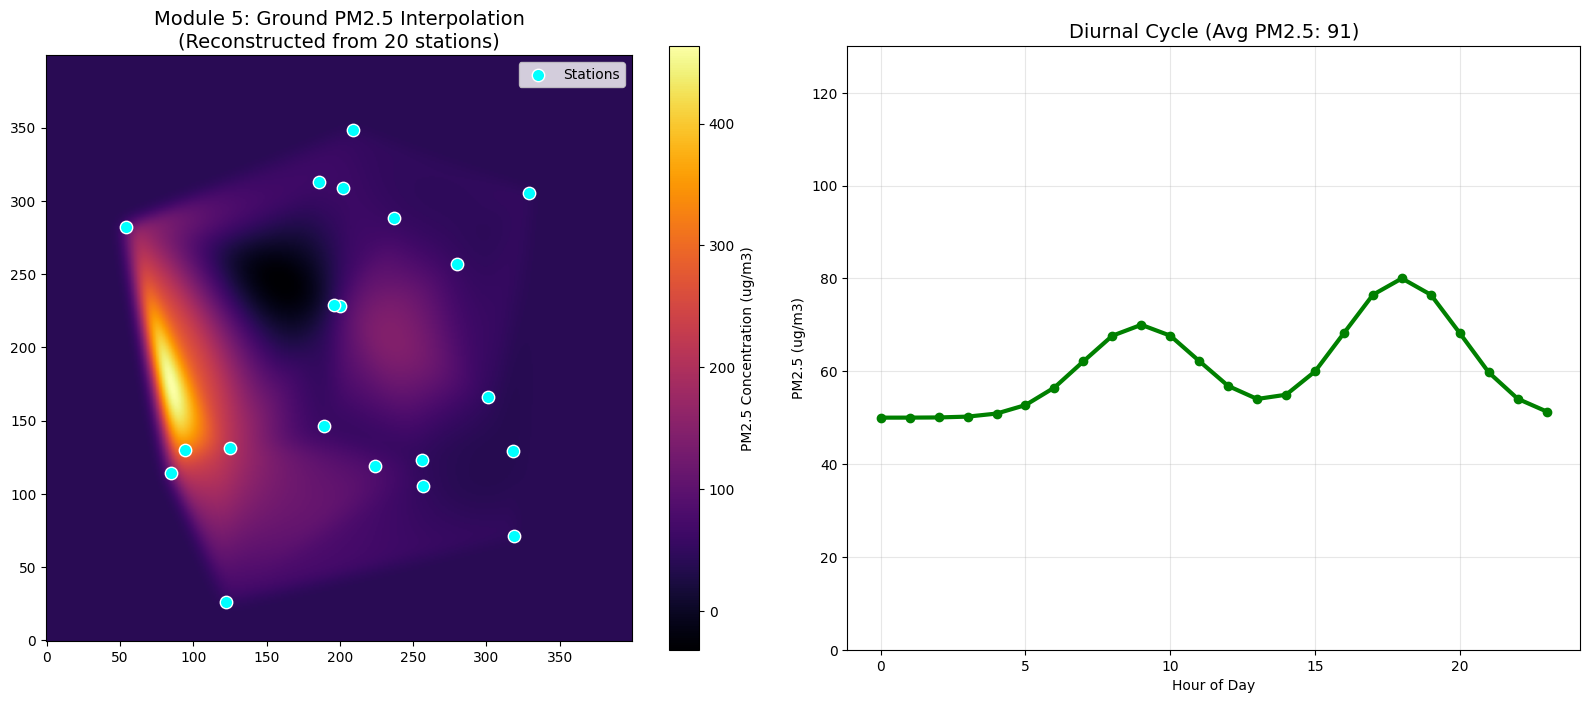

In [102]:
# Module 5 (Connected to Previous Blocks)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def run_connected_pm25_simulation(input_aod_map):
    """
    Simulates ground stations that 'read' the satellite AOD map
    from Module 1 to generate realistic PM2.5 values.
    """
    height, width = input_aod_map.shape

    # 1. Place Synthetic Ground Stations (Random Locations)
    # We place 20 stations across the grid
    num_stations = 20
    # Random x, y coordinates
    station_x = np.random.randint(10, width-10, num_stations)
    station_y = np.random.randint(10, height-10, num_stations)

    # 2. THE CONNECTION: Sample the Satellite Map
    # We look up the pixel value in 'input_aod_map' at every station location.
    sampled_aod_values = input_aod_map[station_y, station_x]

    # 3. Convert AOD to PM2.5
    # Formula: PM2.5 = Background + (Slope * AOD_Value) + Random_Sensor_Noise
    # Realistically, AOD of 2.5 might correspond to ~400 ug/m3
    background_pm = 40.0
    conversion_factor = 150.0

    station_readings = background_pm + (sampled_aod_values * conversion_factor)
    # Add a little noise (sensors are never perfect)
    station_readings += np.random.normal(0, 10, num_stations)

    # 4. DIP Technique: Interpolation (Points -> Surface)
    # Create the full grid for interpolation
    grid_x, grid_y = np.mgrid[0:width, 0:height]

    # Interpolate using 'cubic' method for smoother results
    pm25_interpolated = griddata(
        (station_x, station_y),
        station_readings,
        (grid_x, grid_y),
        method='cubic',
        fill_value=background_pm
    )

    # Handle NaN values at edges (fill with background)
    pm25_interpolated = np.nan_to_num(pm25_interpolated, nan=background_pm)

    # 5. Smooth the final result
    pm25_interpolated = gaussian_filter(pm25_interpolated, sigma=5)

    return station_x, station_y, station_readings, pm25_interpolated

def generate_diurnal_curves_connected(is_smoky_day=True):
    hours = np.arange(0, 24)
    # Base traffic curve
    traffic = 20 * np.exp(-(hours - 9)**2 / 8) + 30 * np.exp(-(hours - 18)**2 / 8)

    if is_smoky_day:
        # If the simulation detected smoke, add the inversion spike
        base = 150
        smoke_impact = 200 * np.exp(-(hours - 22)**2 / 15)
    else:
        # Clean day
        base = 50
        smoke_impact = 0

    return hours, base + traffic + smoke_impact

# --- Execution ---

# 1. CHECK FOR INPUT from Module 1
try:
    input_map = mod1_smoke_map
    print("Successfully connected to Module 1 Smoke Map.")
except NameError:
    print("Module 1 data missing. Using dummy data.")
    input_map = np.zeros((400, 400))
    input_map[200:300, 200:300] = 2.0 # Dummy blob

# 2. Run Simulation
st_x, st_y, readings, pm25_map = run_connected_pm25_simulation(input_map)

# 3. Generate Diurnal Curve based on average reading
avg_reading = np.mean(readings)
is_heavy_pollution = avg_reading > 100
hours, curve = generate_diurnal_curves_connected(is_heavy_pollution)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: The Ground Interpolation
# This map looks similar to Module 1, but "reconstructed" from scattered points
im = axes[0].imshow(pm25_map.T, cmap='inferno', origin='lower') # Transpose to match coordinates
axes[0].scatter(st_x, st_y, c='cyan', edgecolors='white', s=80, label='Stations')
axes[0].set_title(f'Module 5: Ground PM2.5 Interpolation\n(Reconstructed from {len(st_x)} stations)', fontsize=14)
plt.colorbar(im, ax=axes[0], label='PM2.5 Concentration (ug/m3)')
axes[0].legend()

# Plot B: The Diurnal Curve
color = 'red' if is_heavy_pollution else 'green'
axes[1].plot(hours, curve, color=color, linewidth=3, marker='o')
axes[1].set_title(f'Diurnal Cycle (Avg PM2.5: {int(avg_reading)})', fontsize=14)
axes[1].set_ylabel('PM2.5 (ug/m3)')
axes[1].set_xlabel('Hour of Day')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, max(curve) + 50)

plt.tight_layout()
plt.show()

Using Module 1 Smoke Map for Vertical Slice.


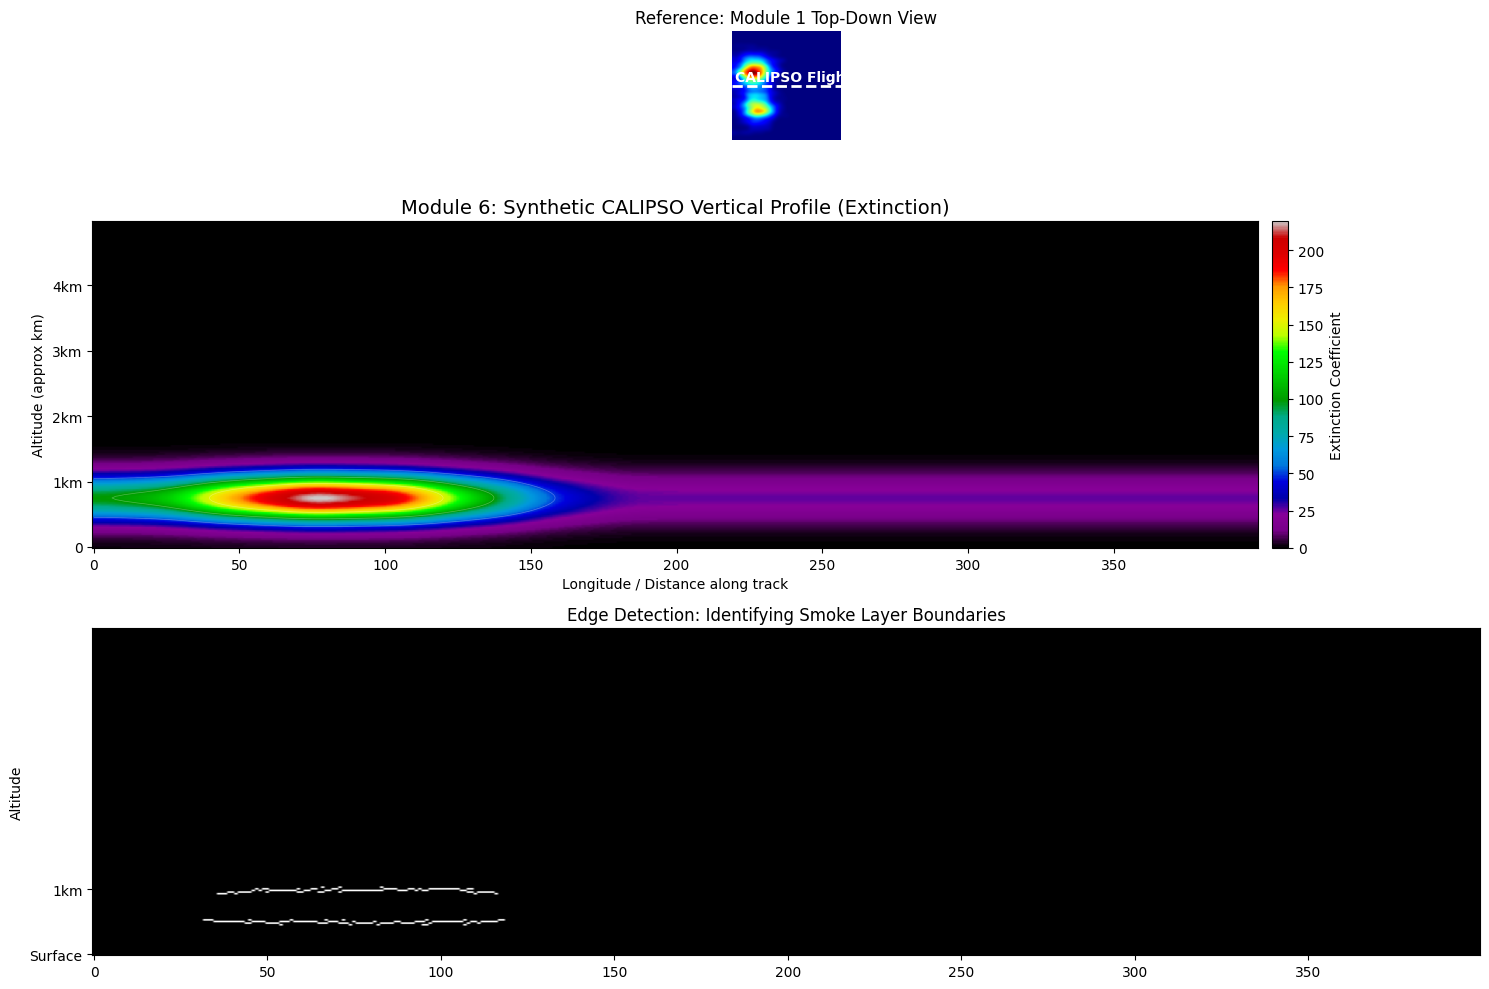

In [103]:
# Module 6 (Vertical CALIPSO Profile)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

def generate_calipso_curtain(input_aod_map):
    """
    Simulates a CALIPSO Lidar 'Curtain' slice.
    It takes a horizontal slice through the center of the Module 1 map
    and expands it vertically to show the altitude of the smoke.
    """

    # 1. Extract the Data Slice (The "Flight Path")
    # We take the middle row of the 2D smoke map (West -> East)
    height, width = input_aod_map.shape
    mid_row = height // 2

    # This 1D array represents the total smoke intensity at each longitude
    ground_track_aod = input_aod_map[mid_row, :]

    # 2. Setup Vertical Grid (Altitude vs Longitude)
    # Y-axis = Altitude (0 to 5km), let's say 200 pixels high
    # X-axis = Distance (matching the map width)
    vertical_res = 200
    calipso_grid = np.zeros((vertical_res, width))

    # 3. DIP Technique: Vertical Gaussian Band
    # We simulate the "Elevated Layer" (300m - 800m).
    # In our 200px grid (0-5km), 1km is approx pixel 40.
    layer_center = 30  # Pixel index for ~750m altitude
    layer_thickness = 10 # Standard deviation

    # Create the vertical Gaussian shape
    y_indices = np.arange(vertical_res)
    gaussian_profile = np.exp(-(y_indices - layer_center)**2 / (2 * layer_thickness**2))

    # 4. Populate the Grid
    # For every column (longitude), we place the Gaussian smoke plume,
    # SCALED by the intensity of the AOD map at that location.
    for x in range(width):
        intensity = ground_track_aod[x]
        # If AOD is high, the vertical layer is dense.
        calipso_grid[:, x] = gaussian_profile * intensity * 255

    # 5. DIP Technique: 2D Smoothing
    # Real atmosphere is fluid; smooth out any pixelation
    calipso_grid = gaussian_filter(calipso_grid, sigma=2)

    # 6. DIP Technique: Edge Detection (Boundary Layer)
    # Find the top and bottom of the smoke cloud
    # We use Canny edge detection on the generated image
    edges = cv2.Canny(calipso_grid.astype(np.uint8), 30, 100)

    return calipso_grid, edges, ground_track_aod

# --- Execution ---

# 1. Connection Check
try:
    # Connect to Module 1
    input_slice = mod1_smoke_map
    print("Using Module 1 Smoke Map for Vertical Slice.")
except NameError:
    # Fallback
    print("Module 1 data missing. Using dummy slice.")
    input_slice = np.zeros((400, 400))
    input_slice[200, 50:150] = 2.0 # Fake smoke on left

# 2. Run Simulation
lidar_data, plume_edges, track_profile = generate_calipso_curtain(input_slice)

# --- Visualization ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[1, 3, 3])

# Plot 1: The Reference Map (Where did we slice?)
ax1 = fig.add_subplot(gs[0])
ax1.imshow(input_slice, cmap='jet')
ax1.axhline(200, color='white', linestyle='--', linewidth=2)
ax1.text(10, 180, 'CALIPSO Flight Path', color='white', weight='bold')
ax1.set_title('Reference: Module 1 Top-Down View', fontsize=12)
ax1.axis('off')

# Plot 2: The CALIPSO Curtain (Vertical Extinction)
ax2 = fig.add_subplot(gs[1])
# 'nipy_spectral' is standard for Lidar plots (black background, colored clouds)
im2 = ax2.imshow(lidar_data, cmap='nipy_spectral', aspect='auto', origin='lower')
# DIP Technique: Contour Delineation
ax2.contour(lidar_data, levels=[50, 100, 150], colors='white', alpha=0.3, linewidths=0.5)

ax2.set_title('Module 6: Synthetic CALIPSO Vertical Profile (Extinction)', fontsize=14)
ax2.set_ylabel('Altitude (approx km)')
# Custom Y-ticks to simulate altitude
ax2.set_yticks([0, 40, 80, 120, 160])
ax2.set_yticklabels(['0', '1km', '2km', '3km', '4km'])
ax2.set_xlabel('Longitude / Distance along track')
cbar = plt.colorbar(im2, ax=ax2, pad=0.01)
cbar.set_label('Extinction Coefficient')

# Plot 3: Edge Detection (The Boundary)
ax3 = fig.add_subplot(gs[2], sharex=ax2)
ax3.imshow(plume_edges, cmap='gray', aspect='auto', origin='lower')
ax3.set_title('Edge Detection: Identifying Smoke Layer Boundaries', fontsize=12)
ax3.set_ylabel('Altitude')
ax3.set_yticks([0, 40])
ax3.set_yticklabels(['Surface', '1km'])

plt.tight_layout()
plt.show()

<>:89: SyntaxWarning: invalid escape sequence '\T'
<>:89: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-486351904.py:89: SyntaxWarning: invalid escape sequence '\T'
  axes[0].set_title('Module 7: Vertical Temperature Profile ($\Theta_v$)', fontsize=14)


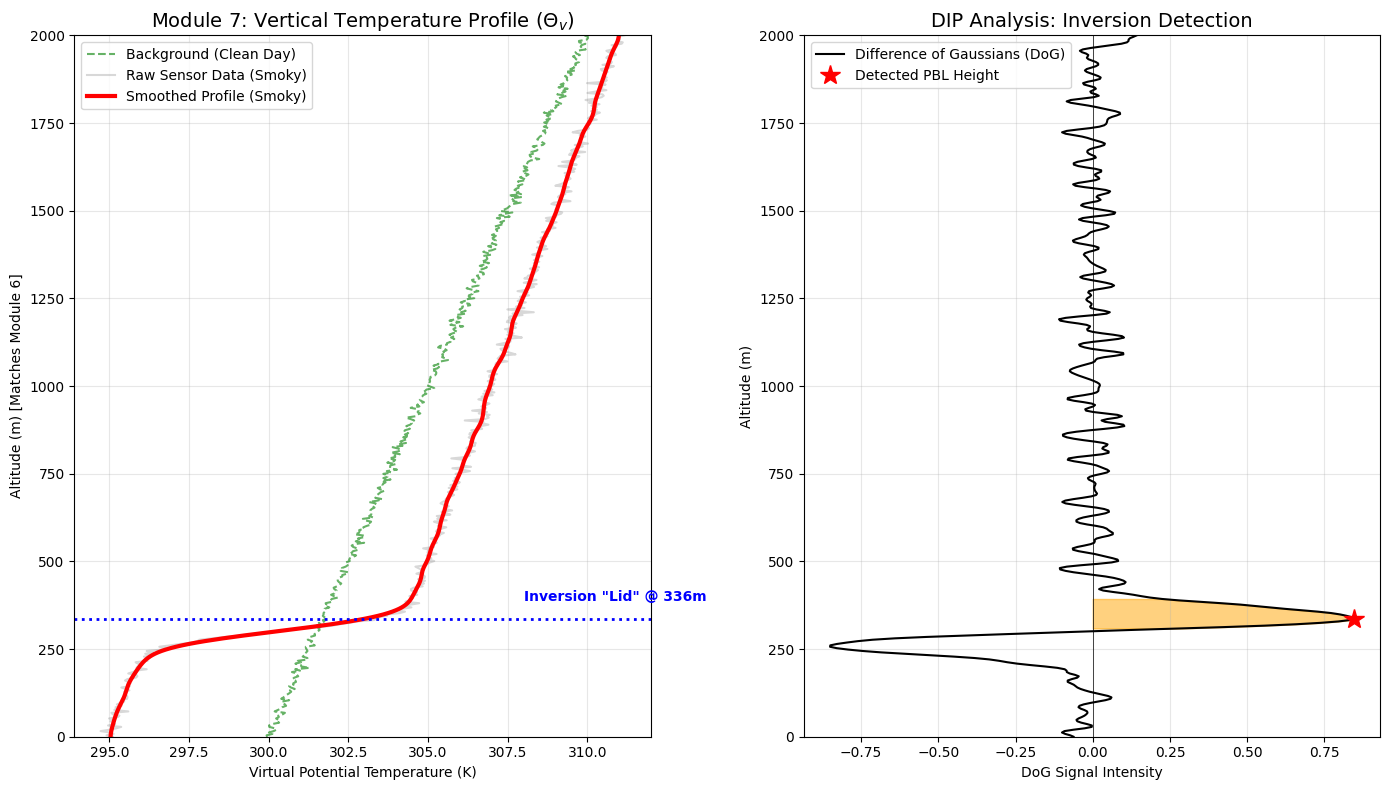

Detected Planetary Boundary Layer (PBL) Height: 336.67 meters
Conclusion: Smoke generated in Mod 2 and transported in Mod 1 is TRAPPED below this line.


In [104]:
# Module 7 (Radiosonde Theta_v Profiles)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

def simulate_radiosonde_data():
    """
    Generates synthetic vertical profiles of Virtual Potential Temperature (Theta_v).
    Simulates the difference between a Clean Day (Free convection)
    and a Smoky Day (Capped inversion).
    """

    # 1. Setup Height Vector (0m to 2000m)
    heights = np.linspace(0, 2000, 500) # 500 data points

    # ---------------------------------------------------------
    # Scenario A: Background / Clean Day
    # ---------------------------------------------------------
    # Atmosphere is unstable/neutral. Theta_v increases steadily.
    # Base temp 300K, lapse rate ensures steady rise.
    theta_clean = 300 + (0.005 * heights)
    # Add sensor noise
    theta_clean += np.random.normal(0, 0.1, len(heights))

    # ---------------------------------------------------------
    # Scenario B: Smoky Day (Inversion Event)
    # ---------------------------------------------------------
    # 1. Surface is cooler (smoke blocks sun)
    theta_smoky = 295 + (0.004 * heights)

    # 2. CREATE THE INVERSION (The "Lid") at 300m
    # We add a logistic sigmoid function to create a sharp temperature JUMP.
    # This matches the bottom of the smoke layer from Module 6.
    inversion_altitude = 300
    strength = 8.0 # degrees Kelvin jump

    # Sigmoid function to smooth the jump
    sigmoid = 1 / (1 + np.exp(-(heights - inversion_altitude) / 20))
    theta_smoky += (strength * sigmoid)

    # Add sensor noise
    theta_smoky += np.random.normal(0, 0.15, len(heights))

    # ---------------------------------------------------------
    # DIP Technique 1: Curve Smoothing
    # ---------------------------------------------------------
    # Radiosonde data is noisy; we smooth it to see the trend.
    theta_smoky_smooth = gaussian_filter(theta_smoky, sigma=5)

    # ---------------------------------------------------------
    # DIP Technique 2: Difference-of-Gaussians (DoG)
    # ---------------------------------------------------------
    # To find the inversion mathematically, we use DoG.
    # It acts like a Band-pass filter to highlight rapid changes (gradients).

    g1 = gaussian_filter(theta_smoky, sigma=2)  # Fine detail
    g2 = gaussian_filter(theta_smoky, sigma=10) # Coarse detail
    dog_signal = g1 - g2

    # ---------------------------------------------------------
    # DIP Technique 3: Peak Detection -> PBL Height
    # ---------------------------------------------------------
    # The inversion causes a massive spike in the DoG signal.
    # We find where that spike is to identify the Planetary Boundary Layer (PBL).
    peaks, _ = find_peaks(dog_signal, height=0.5)

    pbl_height_idx = peaks[0] if len(peaks) > 0 else 0
    pbl_height_m = heights[pbl_height_idx]

    return heights, theta_clean, theta_smoky, theta_smoky_smooth, dog_signal, pbl_height_m

# --- Execution ---
z, th_clean, th_smoky, th_smooth, dog, pbl_loc = simulate_radiosonde_data()

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: The Vertical Profiles (Meteorological Standard: Z on Y-axis)
axes[0].plot(th_clean, z, 'g--', label='Background (Clean Day)', alpha=0.6)
axes[0].plot(th_smoky, z, 'gray', alpha=0.3, label='Raw Sensor Data (Smoky)')
axes[0].plot(th_smooth, z, 'r-', linewidth=3, label='Smoothed Profile (Smoky)')

# Mark the Inversion
axes[0].axhline(pbl_loc, color='blue', linestyle=':', linewidth=2)
axes[0].text(308, pbl_loc + 50, f'Inversion "Lid" @ {int(pbl_loc)}m', color='blue', weight='bold')

# Formatting Plot 1
axes[0].set_title('Module 7: Vertical Temperature Profile ($\Theta_v$)', fontsize=14)
axes[0].set_ylabel('Altitude (m) [Matches Module 6]')
axes[0].set_xlabel('Virtual Potential Temperature (K)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 2000)

# Plot 2: The DIP Analysis (DoG Signal)
axes[1].plot(dog, z, 'k-', label='Difference of Gaussians (DoG)')
axes[1].fill_betweenx(z, 0, dog, where=(dog > 0.2), color='orange', alpha=0.5)

# Mark the Detection
axes[1].plot(dog[int(np.where(z==pbl_loc)[0][0])], pbl_loc, 'r*', markersize=15, label='Detected PBL Height')

# Formatting Plot 2
axes[1].set_title('DIP Analysis: Inversion Detection', fontsize=14)
axes[1].set_xlabel('DoG Signal Intensity')
axes[1].set_ylabel('Altitude (m)')
axes[1].axvline(0, color='k', linestyle='-', linewidth=0.5)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

print(f"Detected Planetary Boundary Layer (PBL) Height: {pbl_loc:.2f} meters")
print("Conclusion: Smoke generated in Mod 2 and transported in Mod 1 is TRAPPED below this line.")

Module 8: Connected to Smoke Map.


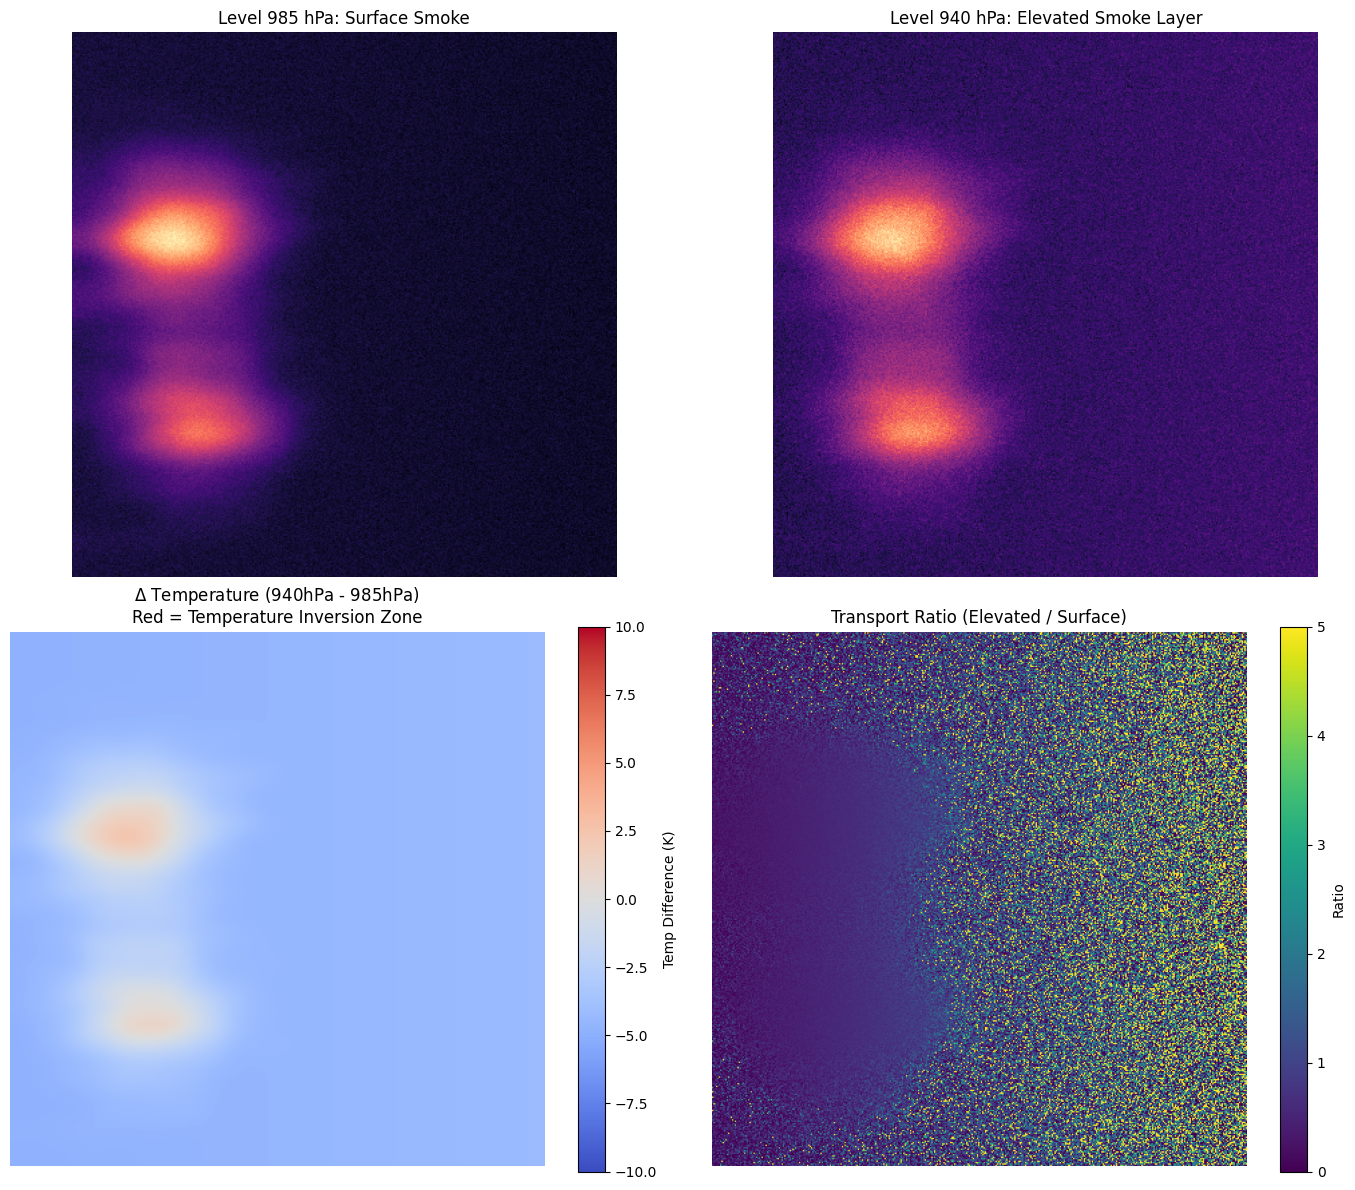

In [105]:
# Module 8 (MERRA-2 Aerosol Vertical Structure)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_merra_layers(input_smoke_map):
    """
    Simulates BC (Black Carbon) and OC (Organic Carbon) concentrations
    at two different atmospheric pressure levels to visualize transport.
    """
    height, width = input_smoke_map.shape

    # ---------------------------------------------------------
    # 1. Create Masks for Source (Punjab) vs Downwind (Delhi)
    # ---------------------------------------------------------
    mask_source = np.linspace(1.0, 0.2, width)
    mask_source = np.tile(mask_source, (height, 1))

    mask_downwind = np.linspace(0.2, 1.0, width)
    mask_downwind = np.tile(mask_downwind, (height, 1))

    # ---------------------------------------------------------
    # 2. Simulate Aerosol Levels (BC + OC)
    # ---------------------------------------------------------

    # LEVEL 985 hPa (Near Surface) - High at Source
    aerosol_985 = input_smoke_map * mask_source * 100

    # LEVEL 940 hPa (Elevated) - High Downwind (Trapped)
    aerosol_940 = input_smoke_map * mask_downwind * 120

    # Add noise
    aerosol_985 += np.random.normal(0, 5, (height, width))
    aerosol_940 += np.random.normal(0, 5, (height, width))

    # ---------------------------------------------------------
    # 3. DIP Technique: Image Subtraction (Temperature Inversion)
    # ---------------------------------------------------------
    temp_985 = np.full((height, width), 295.0)
    temp_940 = np.full((height, width), 290.0)

    # Create Inversion Anomaly over Delhi
    heating_anomaly = input_smoke_map * mask_downwind * 8.0
    temp_940 = temp_940 + heating_anomaly

    # DIP: Subtraction Map
    delta_temp_map = temp_940 - temp_985

    # ---------------------------------------------------------
    # 4. DIP Technique: Ratio Image (BC Ratio)
    # ---------------------------------------------------------
    transport_ratio = (aerosol_940 + 1) / (aerosol_985 + 1)

    return aerosol_985, aerosol_940, delta_temp_map, transport_ratio

# --- Execution ---
try:
    input_data_m8 = mod1_smoke_map
    print("Module 8: Connected to Smoke Map.")
except NameError:
    print("Module 1 missing. Using dummy data.")
    input_data_m8 = np.zeros((400, 400))
    input_data_m8[:, :200] = 1.0

aer_surf, aer_aloft, inv_map, ratio_map = generate_merra_layers(input_data_m8)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Surface Smoke
axes[0, 0].imshow(aer_surf, cmap='magma')
axes[0, 0].set_title('Level 985 hPa: Surface Smoke', fontsize=12)
axes[0, 0].axis('off')

# Plot 2: Elevated Smoke
axes[0, 1].imshow(aer_aloft, cmap='magma')
axes[0, 1].set_title('Level 940 hPa: Elevated Smoke Layer', fontsize=12)
axes[0, 1].axis('off')

# Plot 3: Temperature Inversion (CORRECTED LINE BELOW)
# We added r'...' to tell Python to treat the string as raw text
im3 = axes[1, 0].imshow(inv_map, cmap='coolwarm', vmin=-10, vmax=10)
axes[1, 0].set_title(r'$\Delta$ Temperature (940hPa - 985hPa)' + '\nRed = Temperature Inversion Zone', fontsize=12)
plt.colorbar(im3, ax=axes[1, 0], label='Temp Difference (K)')
axes[1, 0].axis('off')

# Plot 4: Transport Ratio
im4 = axes[1, 1].imshow(ratio_map, cmap='viridis', vmin=0, vmax=5)
axes[1, 1].set_title('Transport Ratio (Elevated / Surface)', fontsize=12)
plt.colorbar(im4, ax=axes[1, 1], label='Ratio')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Module 9: Connected to Smoke Map.


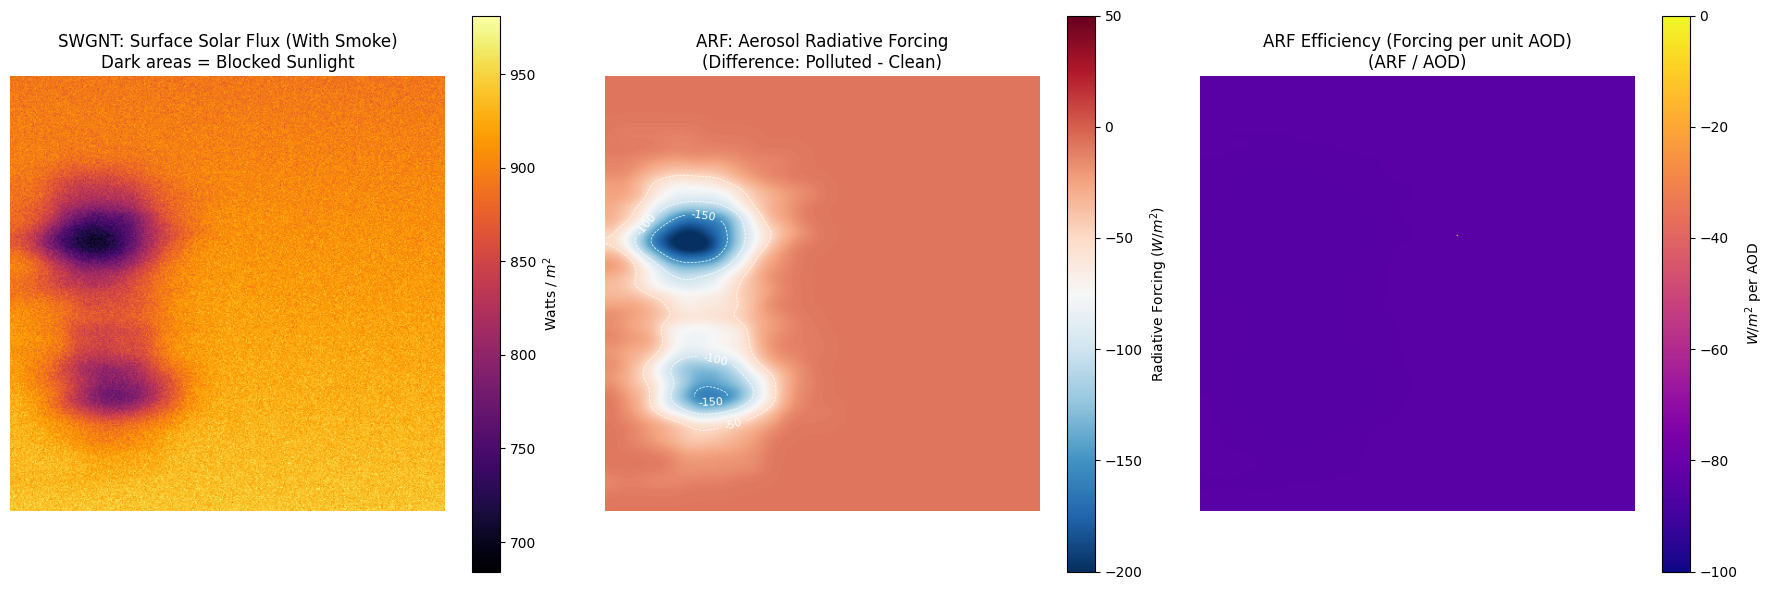

In [106]:
# Module 9 (Synthetic Radiative Forcing)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_radiative_forcing(input_aod_map):
    """
    Simulates the reduction in surface solar radiation due to aerosols.
    Calculates ARF (Absolute Forcing) and ARF_eff (Forcing Efficiency).
    """
    height, width = input_aod_map.shape

    # ---------------------------------------------------------
    # 1. Simulate Clean Conditions (SWGNTCLN)
    # ---------------------------------------------------------
    # Solar flux naturally varies slightly by latitude (sun angle).
    # We create a gradient: Higher flux at bottom (South) than top (North).
    gradient = np.linspace(900, 950, height).reshape(-1, 1) # Watts per m2
    swgnt_clean = np.tile(gradient, (1, width))

    # Add some "Cloud Noise" (Natural variation not related to smoke)
    clouds = np.random.normal(0, 10, (height, width))
    swgnt_clean += clouds

    # ---------------------------------------------------------
    # 2. Simulate Polluted Conditions (SWGNT)
    # ---------------------------------------------------------
    # Physics: Surface Flux = Clean Flux - (Sensitivity * AOD)
    # Sensitivity: How many Watts are blocked per unit of AOD? (e.g., 85 W/m2)
    forcing_sensitivity = 85.0

    # Calculate the reduction caused by the specific smoke map from Module 1
    reduction = input_aod_map * forcing_sensitivity

    # The actual flux reaching the ground
    swgnt_polluted = swgnt_clean - reduction

    # ---------------------------------------------------------
    # 3. DIP Technique: Image Subtraction -> ARF Map
    # ---------------------------------------------------------
    # Aerosol Radiative Forcing = Polluted - Clean
    # This will result in NEGATIVE values (representing energy loss/cooling)
    arf_map = swgnt_polluted - swgnt_clean

    # ---------------------------------------------------------
    # 4. DIP Technique: Division -> ARF Efficiency Map
    # ---------------------------------------------------------
    # ARF_eff = ARF / AOD
    # This shows how "potent" the smoke is per unit thickness.

    # Avoid division by zero (add small epsilon)
    arf_efficiency = arf_map / (input_aod_map + 0.001)

    # Mask out areas with very low AOD (clean air) to avoid noisy division artifacts
    mask = input_aod_map > 0.1
    arf_efficiency = np.where(mask, arf_efficiency, 0)

    return swgnt_clean, swgnt_polluted, arf_map, arf_efficiency

# --- Execution ---

# 1. Connection Check
try:
    input_data_m9 = mod1_smoke_map
    print("Module 9: Connected to Smoke Map.")
except NameError:
    print("Module 1 missing. Using dummy data.")
    input_data_m9 = np.zeros((400, 400))
    cv2.circle(input_data_m9, (200, 200), 100, 2.0, -1)
    input_data_m9 = gaussian_filter(input_data_m9, sigma=20)

# 2. Run Simulation
flux_clean, flux_dirty, arf, arf_eff = generate_radiative_forcing(input_data_m9)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: SWGNT (The Polluted Surface View)
# Darker areas = Less sunlight reaching the ground
im1 = axes[0].imshow(flux_dirty, cmap='inferno')
axes[0].set_title('SWGNT: Surface Solar Flux (With Smoke)\nDark areas = Blocked Sunlight', fontsize=12)
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Watts / $m^2$')
axes[0].axis('off')

# Plot 2: ARF (The Forcing / Subtraction)
# We use 'RdBu_r' (Red-Blue reversed). Blue = Cooling (Negative), Red = Warming.
# Since smoke blocks sun, this map should be mostly BLUE.
im2 = axes[1].imshow(arf, cmap='RdBu_r', vmin=-200, vmax=50)
axes[1].set_title('ARF: Aerosol Radiative Forcing\n(Difference: Polluted - Clean)', fontsize=12)

# DIP Technique: Contours
# We add white lines to show levels of energy loss (-50, -100, -150 W/m2)
contour = axes[1].contour(arf, levels=[-150, -100, -50], colors='white', linewidths=0.5)
axes[1].clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Radiative Forcing ($W/m^2$)')
axes[1].axis('off')

# Plot 3: ARF Efficiency (The Division)
im3 = axes[2].imshow(arf_eff, cmap='plasma', vmin=-100, vmax=0)
axes[2].set_title('ARF Efficiency (Forcing per unit AOD)\n(ARF / AOD)', fontsize=12)
cbar3 = plt.colorbar(im3, ax=axes[2])
cbar3.set_label('$W/m^2$ per AOD')
axes[2].axis('off')

plt.tight_layout()
plt.show()

All previous module data loaded successfully.


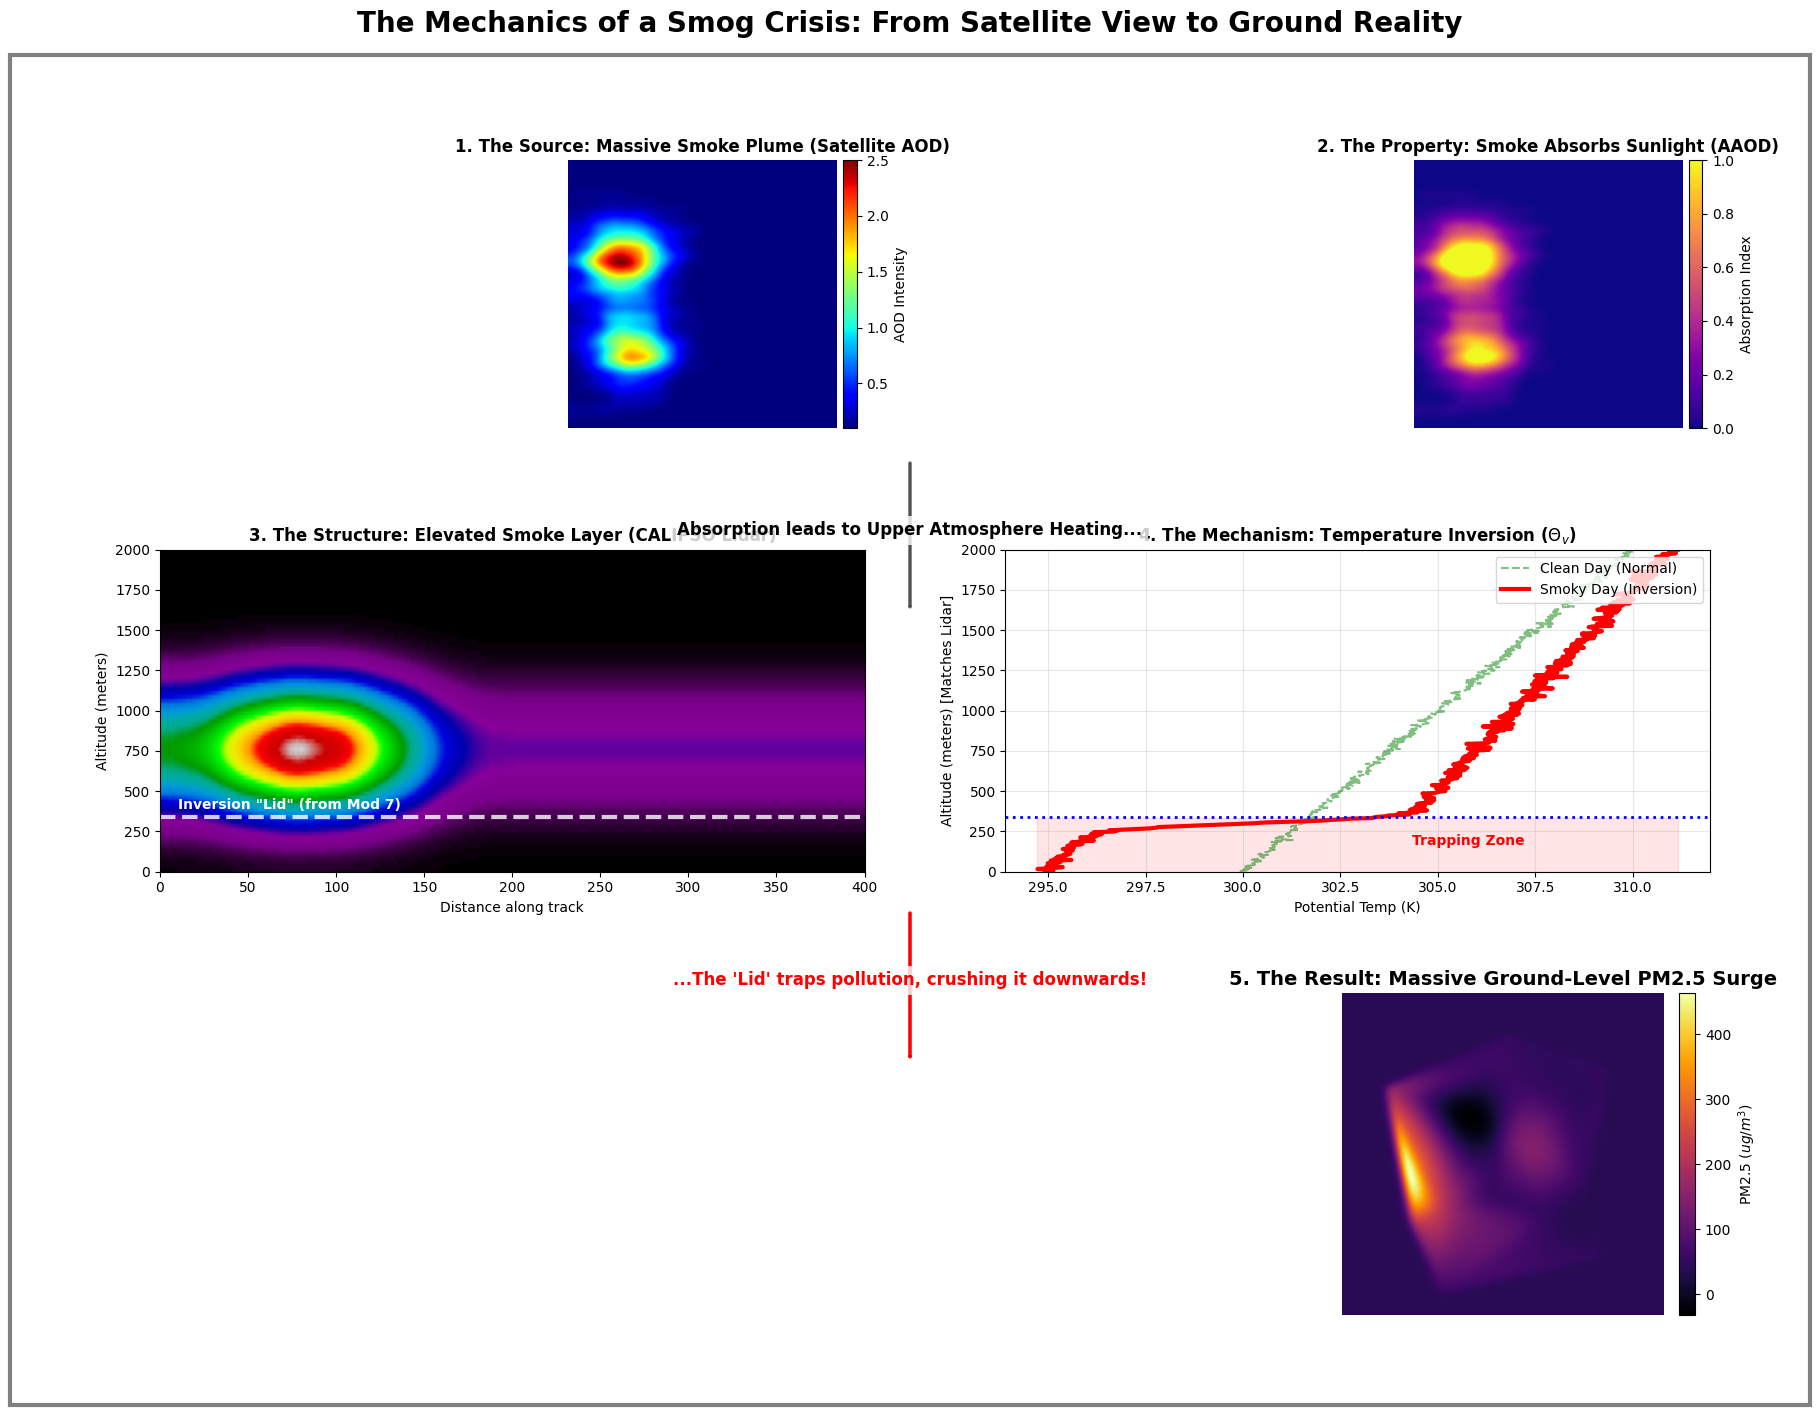

In [107]:
# Module 10: Final Mechanistic DIP Composite
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.patches import FancyArrowPatch

# --- 0. Data Gathering (Ensuring inputs exist) ---
try:
    data_aod = mod1_smoke_map          # Mod 1
    data_aaod = aaod_map               # Mod 3
    data_pm25 = pm25_map               # Mod 5
    data_lidar = lidar_data            # Mod 6
    # Mod 7 data
    z_prof = z
    th_clean_prof = th_clean
    th_smoky_prof = th_smoky
    pbl_height = pbl_loc
    print("All previous module data loaded successfully.")
except NameError:
    print("WARNING: Previous module data missing. Generating placeholders for layout demonstration.")
    data_aod = np.random.rand(400, 400)
    data_aaod = np.random.rand(400, 400)
    data_pm25 = np.random.rand(400, 400)
    data_lidar = np.random.rand(200, 400)
    z_prof = np.linspace(0, 2000, 100)
    th_clean_prof = np.linspace(300, 310, 100)
    th_smoky_prof = np.linspace(295, 305, 100); th_smoky_prof[30:] += 5
    pbl_height = 600

# --- 1. Figure Layout Setup (GridSpec) ---
fig = plt.figure(figsize=(20, 15))
# 3 Rows: Cause (Top), Physics (Middle), Effect (Bottom)
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1.2, 1.2], hspace=0.4, wspace=0.2)

fig.suptitle('The Mechanics of a Smog Crisis: From Satellite View to Ground Reality',
             fontsize=20, weight='bold', y=0.98)

# --- ROW 1: THE CAUSE (Smoke Aloft + Absorption) ---

# Panel 1A: AOD (Smoke Aloft)
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(data_aod, cmap='jet')
ax1.set_title('1. The Source: Massive Smoke Plume (Satellite AOD)', fontsize=12, weight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.03, pad=0.01, label='AOD Intensity')

# Panel 1B: AAOD (Absorption)
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(data_aaod, cmap='plasma')
ax2.set_title('2. The Property: Smoke Absorbs Sunlight (AAOD)', fontsize=12, weight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.03, pad=0.01, label='Absorption Index')

# Annotation Arrow 1
arrow1 = FancyArrowPatch((0.5, 0.68), (0.5, 0.58), transform=fig.transFigure,
                         fc='black', ec='black', arrowstyle='simple,head_width=1,tail_width=0.5', lw=2, alpha=0.6)
fig.add_artist(arrow1)
fig.text(0.5, 0.63, "Absorption leads to Upper Atmosphere Heating...",
         ha='center', fontsize=12, weight='bold', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))


# --- ROW 2: THE ATMOSPHERIC PHYSICS (Vertical Structure & Inversion) ---

# Panel 2A: CALIPSO Vertical Profile
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.imshow(data_lidar, cmap='nipy_spectral', aspect='auto', origin='lower', extent=[0, 400, 0, 5000])
ax3.set_title('3. The Structure: Elevated Smoke Layer (CALIPSO Lidar)', fontsize=12, weight='bold')
ax3.set_ylabel('Altitude (meters)')
ax3.set_xlabel('Distance along track')
ax3.set_ylim(0, 2000)
# Overlay the PBL height
ax3.axhline(pbl_height, color='white', linestyle='--', linewidth=3, alpha=0.8)
ax3.text(10, pbl_height + 50, 'Inversion "Lid" (from Mod 7)', color='white', weight='bold')

# Panel 2B: Theta_v Profile (The Inversion)
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(th_clean_prof, z_prof, 'g--', label='Clean Day (Normal)', alpha=0.5)
ax4.plot(th_smoky_prof, z_prof, 'r-', linewidth=3, label='Smoky Day (Inversion)')

ax4.axhline(pbl_height, color='blue', linestyle=':', linewidth=2)
ax4.fill_betweenx(z_prof, th_smoky_prof.min(), th_smoky_prof.max(), where=(z_prof < pbl_height), color='red', alpha=0.1)
ax4.text(np.mean(th_smoky_prof), pbl_height/2, 'Trapping Zone', color='red', ha='center', weight='bold')

# 1. Added r'' for raw string to handle LaTeX symbol \Theta
ax4.set_title(r'4. The Mechanism: Temperature Inversion ($\Theta_v$)', fontsize=12, weight='bold')
# 2. Fixed syntax error (was =, changed to function call)
ax4.set_ylabel('Altitude (meters) [Matches Lidar]')
ax4.set_xlabel('Potential Temp (K)')
# --------------------------

ax4.set_ylim(0, 2000)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Annotation Arrow 2
arrow2 = FancyArrowPatch((0.5, 0.38), (0.5, 0.28), transform=fig.transFigure,
                         fc='red', ec='red', arrowstyle='simple,head_width=1,tail_width=0.5', lw=2)
fig.add_artist(arrow2)
fig.text(0.5, 0.33, "...The 'Lid' traps pollution, crushing it downwards!",
         ha='center', fontsize=12, weight='bold', color='red', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))


# --- ROW 3: THE GROUND EFFECT (PM2.5 Surge) ---

# Panel 3: Surface PM2.5 Map
ax5 = fig.add_subplot(gs[2, :])
im5 = ax5.imshow(data_pm25.T, cmap='inferno', origin='lower')
ax5.set_title('5. The Result: Massive Ground-Level PM2.5 Surge', fontsize=14, weight='bold')
cbar5 = plt.colorbar(im5, ax=ax5, fraction=0.02, pad=0.01)
cbar5.set_label('PM2.5 ($ug/m^3$)')
ax5.axis('off')

# Final decorative box
rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, transform=fig.transFigure,
                     linewidth=3, edgecolor='gray', facecolor='none', zorder=0)
fig.add_artist(rect)

plt.show()